The AdjointSecondOrderODEModel seeks to infer the forcing functon of a linear second order differential equation of the form:

\begin{equation}
-K_0\frac{d^2s}{dt^2}+u\frac{ds}{dt}+\eta_0 s(t)=\zeta(t)
\end{equation}
with initial conditions:

\begin{equation}
g(s(0),p)=s(0)=0
\end{equation}
and
\begin{equation}
k(\dot{s}(0),p)=\frac{ds(0)}{dt}=0
\end{equation}

The forcing function, $\zeta$ is approximated using Random Fourier Features so that

\begin{equation}
\zeta(t)\sim \sum_{i=1}^{M}\phi_i(t)z_i
\end{equation}

$\zeta$ is then inferred using the adjoint method as in Gahungu et al. (2022).

Additionally, we seek the gradient of some cost function $F=\int_0^Tf(s,p,t)dt$ (which measures the quality of our inference) with respect to the parameters $p={u,\eta_0,k_0}$. To calculate this we follow the methods described in Andrew Bradley's adjoint tutorial (Bradley, 2009). 

First we set 
\begin{equation}
h(s,\dot{s},p,t) = \frac{u}{K_0}\dot{s}+\frac{\eta_0}{K_0}-\frac{f(t)}{K_0}
\end{equation}
so that $\ddot{s}=h(s,\dot{s},p,t)$.
subject to $g$ and $k$. 

We then establish the lagrangian:

\begin{equation}
   L =\int_0^T f(s,p,t)+ \lambda^T(\ddot{s}-h(s,\dot{s},p,t)) dt + \mu^Tg(s(0),p)+\nu^Tk(\dot{s}(0),p) 
\end{equation}

Taking the total derivative with respect to p, integrating by parts and collecting terms gives

\begin{equation}
       d_mL=\int_0^T\delta_mf-\lambda^T\delta_mhdt 
    +(-\dot{\lambda}^T-\lambda^T\delta_{\dot{s}}h)g_{s(0)}^{-1}\delta_pg + \lambda^T(0) k^{-1}_{\dot{s}(0)}\delta_pk 
\end{equation}

subject to 

\begin{equation}
    f_s+\ddot{\lambda}^T+\dot{\lambda}^T\delta_{\dot{s}}h-\lambda^T(\delta_sh-d_t\delta_{\dot{s}}h)=0,
\end{equation}
which is the adjoint equation.

In our case $\delta_pg=\delta_p k=0$, $\delta_mf=0$, $\delta_{\dot{s}(0)}h=0$. Therefore the adjoint equation is given by
\begin{equation}
\delta_s f + \ddot{\lambda}^T +\frac{u}{K_0}\dot{\lambda}^T-\frac{\eta_0}{K_0}\lambda^T=0
\end{equation}
and 
\begin{equation}
d_mL=\int_0^T-\lambda^T\delta_mhdt 
\end{equation}

where 
\begin{equation}
\delta_mh = \left(\frac{\dot{s}}{K_0},\frac{s}{K_0},\frac{-u\dot{s}-\eta_0s+\zeta}{K_0^2}\right).
\end{equation}

We choose the cost function 
\begin{equation}
F = \int^T_0 f(s,p,t)dt = \int^T_0\frac{1}{M}\sum_{i=0}^M (s(t)-y(t))^2\delta(t-t_i)dt,
\end{equation}
where
\begin{equation}
y(t)=\begin{cases}
y_i \ \mathrm{ if } \ t=t_i \\ 0 \ \mathrm{ o.w.}
\end{cases}
\end{equation}
Here, $y_i$ are our observations. 

# Import Modules

In [1]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models import AdjointSecondOrderODEModel as Model #Model module builds basic parts of the ODE problem, combines other classes into full model

'''To use other models in the class, such as the Advection Diffusion Reaction model, 
replace "AdjointSecondOrderODEModel" in the line above with "AdjointAdvectionDiffusionReaction" model
and adjust parameters as appropriate'''

from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

# Establish Sensor Array

Our sensor matrix, X, is an array that has an element for each observation, which consists of the start and end times of the observation period. 

In [2]:
avg=0.01 # time that an observation is taken for
tlocL = np.linspace(0,9.9,20) # observation start times
X= np.zeros((len(tlocL),2)) # initiate X
# Build sensor locations
X[:,0] = tlocL #lower time
X[:,1] = X[:,0]+avg # upper time

/tmp/ipykernel_70633/1345232015.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "xk" (-> color='k'). The keyword argument will take precedence.
  plt.plot((X[:,1]-avg/2),np.zeros(len(X)),'xk',markersize=2,color='b');


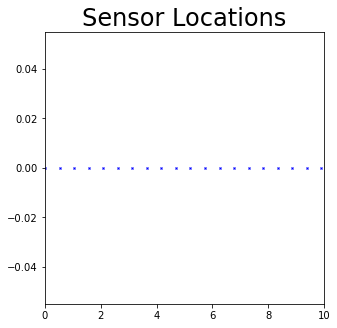

In [3]:
plt.rcParams["figure.figsize"] = (5,5)

plt.xlim(0,10)
plt.title("Sensor Locations",fontsize=24)
plt.plot((X[:,1]-avg/2),np.zeros(len(X)),'xk',markersize=2,color='b');

Using X with then initalise our sensor model, which is used to calculate filter functions.

In [4]:
sensors = FixedSensorModel(X,0) # establish sensor model arguments are sensor locations and spatial averaging (not applicable in 1D case so set to 0)

# Forward Model

Here we generate an artificial source and concentration field using the tools in advectionGP.models. The source is generated over a Nt=100 grid in time.

### Establish forward model parameters

In [5]:
k_0 = -1 #Diffusion coefficient
u=0.8
eta=5
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0],[10])# edges of the grid - in units of time
kForward = EQ(0.6, 4.0) # generate EQ kernel arguments are lengthscale and variance
res = [500] # grid size for time

### Initialise model and calculate ground truth source, concentration and observations

Here we use a constant source at a fixed location, but include code (commented out) for a source term calculated by approximating a gaussian process with an EQ kernel. Any source of the right dimensions can be used to simulate the forward problem.

In [6]:
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #initiate PDE model to build concentration

dt,dt2,Nt = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
#sourceGT = np.ones(m.resolution)  # Example constant source
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs ODE forward model
yTrain= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations

# Inverse Problem Example

In [48]:
#%%timeit
N_feat =200 #Number of features used to infer the source
kInverse = EQ(1, 4) # Initiate kernel for inverse problem
x = np.array([5,1,-5])#+np.random.normal(0,0.1,3)
#x=[1,1,-1]
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=x[2],u=x[0],eta=x[1]) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

Calculating Adjoints...
19/20 
Calculating Phis...
199/200 


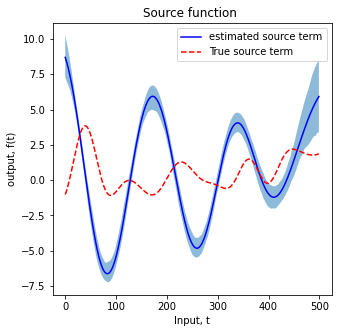

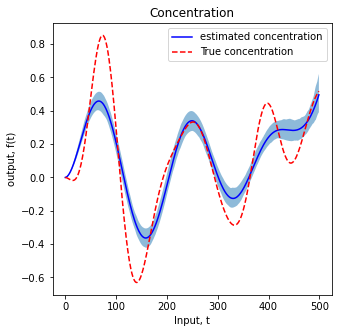

In [49]:
source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

#plt.figure(figsize=(15, 10))

plt.plot(xtest,concInfer,'b-')
plt.plot(xtest,concTrain,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
plt.legend(labels=["estimated concentration","True concentration"])
plt.title("Concentration")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

# Functions to calculate the cost $f$ and the cost derivate $f_s$.

Below is a version that approximates the Dirac-delta using a gaussian, the next cell approximates it using a step function. 

In [50]:
def dcostG(obs,tloc,conc):
    M=len(obs) #number of observations
    eps=0.05 #Gaussian parameter
    dc = np.sum(1/(eps*np.sqrt(np.pi))*np.exp(-(m.coords-tloc)**2/eps**2)*2*(conc[m.getGridCoord(tloc)]-obs)*(1/M),1) # cost derivative approximated with gaussian
    return dc

def costG(obs,tloc,conc):
    M=len(obs) #number of observations
    eps=0.05 #Gaussian parameter
    c = np.sum(1/(eps*np.sqrt(np.pi))*np.exp(-(m.coords-tloc)**2/eps**2)*((conc[m.getGridCoord(tloc)]-obs)**2)*(1/M),1) # cost approximated with gaussian
    return c




In [51]:
def dcost(obs,tloc,conc,model):
    dc=np.zeros(model.resolution) #initialise cost derivative
    M=len(obs) # number of observations
    dc[model.getGridCoord(tloc)] = 2*(conc[model.getGridCoord(tloc)]-obs)*(1/M) # cost derivative approximated with step functions
    return dc

def cost(obs,tloc,conc,model):
    c=np.zeros(model.resolution) # initialise cost
    M=len(obs) # number of observations
    c[model.getGridCoord(tloc)] = ((conc[model.getGridCoord(tloc)]-obs)**2)*(1/M) # cost approximated with hill function
    return c

# Function to calculate the adjoint equation

In [52]:
def computeGradientAdjoint(dcost,model):
    """
    Runs the backward second order ODE (adjoint problem)
    Gets called for an observation instance (H).
    (v is the result of the adjoint operation)
    """
    dt,dt2,Nt = model.getGridStepSize()
    k_0=model.k_0
    u=model.u
    eta=model.eta
    v=np.zeros(((model.resolution)))
    
    #Boundary conditions
    v[Nt-1] = 0
    v[Nt-2] = (1.0/(1-(u*dt/(2*k_0))))*(-dcost[Nt-1]*(dt2)- v[Nt-1]-u*dt*v[Nt-1]/(k_0*2.0)+ 2*v[Nt-1]+(eta/k_0)*(dt2)*v[Nt-1])

    # Calculation away from boundary
    for i in reversed(range(1,Nt-1)):
        #i=Nt-j-2
        v[i-1]=(1.0/(1-(u*dt/(2*k_0))))*(-dcost[i]*(dt2)- v[i+1]-u*dt*v[i+1]/(k_0*2.0)+ 2*v[i]+(eta/k_0)*(dt2)*v[i])

    return v

# Function to calculate the Lagrangian derivative, the cost and the derivative of the cost for a given $p$

In [53]:
def d_mL(k_0,u,eta,model,obs,tloc,source):
    
    # change parameters in model object
    model.k_0=k_0 
    model.u=u
    model.eta=eta
    
    # calculate useful valyes
    dt,dt2,Nt = model.getGridStepSize()
    
    # compute concentration with new parameters
    conc=model.computeConcentration(source)
    
    #compute cost derivative and cost
    dc=dcost(obs,tloc,conc,model)
    c=cost(obs,tloc,conc,model)
    
    # derivative of h operator with respect to parameters
    dmH=np.array([np.gradient(conc,dt[0])/k_0,conc/k_0,(-u*np.gradient(conc,dt[0])-eta*conc+source)/k_0**2])

    # compute and calculate Lagrangian derivative integral
    integrand = -computeGradientAdjoint(dc,model)*dmH
    L_m = np.trapz(integrand,dx=dt)
    #L_m = np.sum(integrand)*dt #alternate calculation using naive numerical integration
    return L_m, dc,c#, integrand, dmH


In [13]:
L_m, dc,c, integrand, dmH = d_mL(k_0,u,eta,mInfer,yTrain,tlocL,sourceInfer)

ValueError: not enough values to unpack (expected 5, got 3)

In [14]:
integrand.shape

NameError: name 'integrand' is not defined

# Naive gradient descent (output used to test gradient calculation)

In [15]:
reps=5000

# initialise outputs
p=np.zeros((3,reps)) # parameters
d=np.zeros((3,reps-1)) # derivative
dTest=np.zeros((3,reps-1)) # forward difference derivative approximation
dTest2=np.zeros((3,reps-1)) # central difference derivative approximation
Fc=np.zeros((1,reps-1)) # integrated cost function
p[:,0]=np.array([u,eta,k_0])+np.random.normal(0,0.5,3) # first parameter value
eps2=1e-12
for i in range(reps-1):
    [u1,eta1,k_01] = p[:,i]
    
    dmL, dc,c=d_mL(k_01,u1,eta1,mInfer,yTrain,tlocL,sourceInfer)
    d[:,i]=dmL
    p[:,i+1]=p[:,i]-0.1*dmL
    Fc[:,i] = sum(c)*dt
    dmL2, dc2,c2=d_mL(k_01,u1+eps2,eta1,mInfer,yTrain,tlocL,sourceInfer)
    dmL3, dc3,c3=d_mL(k_01,u1,eta1+eps2,mInfer,yTrain,tlocL,sourceInfer)
    dmL4, dc4,c4=d_mL(k_01+eps2,u1,eta1,mInfer,yTrain,tlocL,sourceInfer)
    # dmL5, dc5,c5=d_mL(dmH,k_01,u1-eps2,eta1,m,yTrain,tlocL,sourceInfer)
    #dmL6, dc6,c6=d_mL(dmH,k_01,u1,eta1-eps2,m,yTrain,tlocL,sourceInfer)
    # dmL7, dc7,c7=d_mL(dmH,k_01-eps2,u1,eta1,m,yTrain,tlocL,sourceInfer)
    
    #dTest[:,i:i+1] = (np.array((sum((c2))*dt-sum((c5))*dt,sum((c3))*dt-sum((c6))*dt,sum((c4))*dt-sum((c7))*dt)))/(2*eps2)
    dTest2[:,i:i+1] = ((sum((c2))*dt,sum((c3))*dt,sum((c4))*dt)-(sum(c)*dt))/(eps2)
    
    

MSE between adjoint calculated gradient and gradient test

In [16]:
np.sum((dTest2-d)**2)/m.resolution

array([4.72424945e+115])

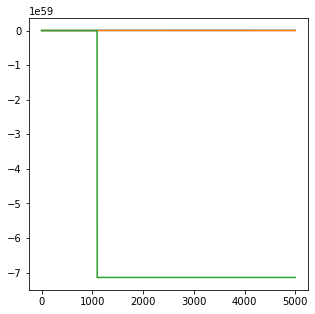

In [17]:
plt.plot(p.T)

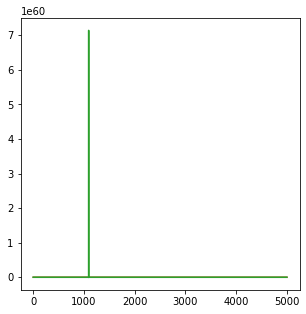

In [18]:
plt.plot(d.T);

In [19]:
d

array([[-9.61962828e-002, -9.33117302e-002, -9.05887447e-002, ...,
         2.66143616e-121,  2.66143616e-121,  2.66143616e-121],
       [-1.71883364e-002, -1.68836255e-002, -1.65924047e-002, ...,
         8.88428578e-121,  8.88428578e-121,  8.88428578e-121],
       [-4.66681940e-002, -4.62715564e-002, -4.58734748e-002, ...,
        -8.98216278e-122, -8.98216278e-122, -8.98216278e-122]])

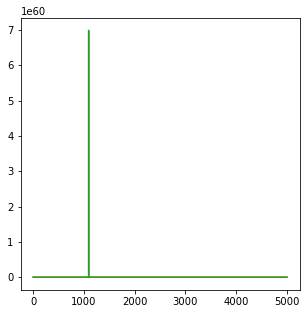

In [20]:
plt.plot(dTest2.T);

In [21]:
p[:,i-1]

array([ 5.05805670e+56, -6.95048498e+55, -7.14078264e+59])

In [22]:
from scipy.optimize import minimize

### Functions for cost and derivative for use with scipy optimiser

In [54]:
def FullCost(x,model,obs,tloc,source):
    model.k_0=x[2]
    model.u=x[0]
    model.eta=x[1]
    dt,dt2,Nt = model.getGridStepSize()
    conc=model.computeConcentration(source)

    c1=cost(obs,tloc,conc,model)
    
    c = np.sum(c1)*dt
    
    return c

In [55]:
def FullDeriv(x,model,obs,tloc,source):
    model.k_0=x[2]
    model.u=x[0]
    model.eta=x[1]
    dt,dt2,Nt = model.getGridStepSize()
    conc=model.computeConcentration(source)
    dmH=np.array([np.gradient(conc,dt[0])/model.k_0,conc/model.k_0,(-model.u*np.gradient(conc,dt[0])-model.eta*conc+source)/model.k_0**2])
    dc=dcost(obs,tloc,conc,model)
    c=cost(obs,tloc,conc,model)
    #print(np.sum((c/2)**2))
    integrand = -computeGradientAdjoint(dc,model)*dmH
    L_m = np.trapz(integrand,dx=dt)
    #L_m = np.sum(integrand)*dt
    return L_m

In [56]:
x0 = x
x0 = np.array([5,5,-5])

Possible constraints to apply

In [57]:
from scipy.optimize import NonlinearConstraint
con = lambda x: x[1]**2 - 4*x[0]*x[2]
nlc = NonlinearConstraint(con, -np.inf, 0)

In [58]:
conL = lambda x: x[0]/x[2]
lc = NonlinearConstraint(conL,-np.inf,0)

### scipy minimiser

In [59]:
result = minimize(FullCost, x0, method='BFGS', jac=FullDeriv,args=(m,yTrain,tlocL,sourceInfer),options={'disp': True},tol=1e-8)

         Current function value: 0.000454
         Iterations: 24
         Function evaluations: 80
         Gradient evaluations: 69


In [60]:
result

      fun: 0.00045369873317655554
 hess_inv: array([[  258.41552851,  -182.4142213 , -1209.39965182],
       [ -182.4142213 ,  5552.72857728, -1382.48746365],
       [-1209.39965182, -1382.48746365,  6608.00466173]])
      jac: array([6.62210198e-06, 4.42833693e-07, 1.45478270e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 80
      nit: 24
     njev: 69
   status: 2
  success: False
        x: array([ 5.00785539,  0.9811683 , -3.38843976])

In [62]:
x = np.array([5,1,-5])
xs = []
funvalue = []
#x = np.array([u,eta,k_0])
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=x[2],u=x[0],eta=x[1]) #Initiate new model for inference
for i in range(5000):
    mInfer.k0=x[2]
    mInfer.u=x[0]
    mInfer.eta=x[1]
    mInfer.computeModelRegressors() # Compute regressor matrix 
    meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
    sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
    concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source
    dmH=np.array([np.gradient(concInfer,dt[0])/x[2],concInfer/x[2],(-x[0]*np.gradient(concInfer,dt[0])-x[1]*concInfer+sourceInfer)/(x[2]**2)])
    result = minimize(FullCost, x, method='BFGS', jac=FullDeriv,args=(mInfer,yTrain,tlocL,sourceInfer),tol=1e-8)
    x = result.x
    xs.append(x)
    funvalue.append(result.fun)
    if i>1 and np.abs(funvalue[i]-funvalue[i-1]) < 1e-7:
        break 
    print(x,result.fun,np.abs(funvalue[i]-funvalue[i-1]))
    

Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
[ 4.81638994  1.44859087 -3.15905666] 0.0004769422767735461 0.0
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
[ 4.37530521  1.4859339  -2.38726321] 0.0004192336762423568 5.7708600531189294e-05
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
[ 4.05940407  1.49040299 -1.95767316] 0.0004052381785075378 1.3995497734819009e-05
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
[ 3.8083777   1.49235581 -1.67481743] 0.00039627759741249366 8.960581095044122e-06
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
[ 3.60118869  1.49209994 -1.46710917] 0.00038818424260919925 8.093354803294416e-06
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
[ 3.42527883  1.48926768 -1.30239294] 0.0003800633833567605 8.120859252438756e-06
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
[ 3.27186696  1.4833131  -1.16412234] 0.00037155570591759004 8.507677439170453e-06
Calculating Adjoint

[ 0.34202414  1.74251046 -0.14226021] 4.5788514408768683e-05 1.2751456898178661e-06
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
[ 0.32862873  1.7519203  -0.14448087] 4.4719406025069174e-05 1.0691083836995095e-06
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
[ 0.31643786  1.75962772 -0.14643813] 4.384594260198088e-05 8.734634230882915e-07
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
[ 0.30541632  1.76572653 -0.14815752] 4.314900164757829e-05 6.969409544025924e-07
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
[ 0.29547739  1.77022215 -0.14963912] 4.260779082638652e-05 5.412108211917693e-07
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
[ 0.28653851  1.77316768 -0.15089293] 4.2197410644815626e-05 4.103801815708946e-07
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
[ 0.27852523  1.77476757 -0.15194902] 4.1894076391147256e-05 3.033342536683706e-07
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 


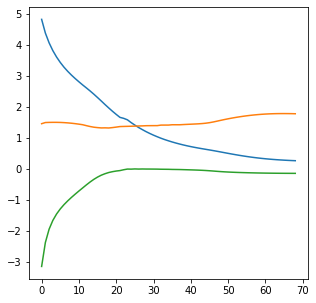

In [66]:
plt.plot(xs);

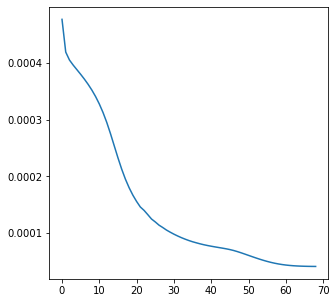

In [67]:
plt.plot(funvalue);

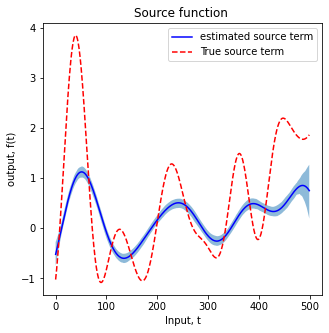

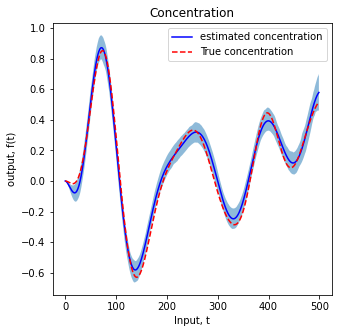

In [68]:
source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

#plt.figure(figsize=(15, 10))

plt.plot(xtest,concInfer,'b-')
plt.plot(xtest,concTrain,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
plt.legend(labels=["estimated concentration","True concentration"])
plt.title("Concentration")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

In [ ]:
np.sum((m.computeConcentration(sourceGT)-mInfer.computeConcentration(sourceInfer))**2)/200

In [ ]:
plt.plot(mInfer.computeConcentration(sourceInfer))

In [ ]:
mInfer.k_0

In [94]:
def getdPhiDerivative1D(model,coords):
    """
    Generates a (N_feat,Nt) matrix of basis vectors using features from generateFeatures 
    Arguments:
        coords: map of all (t) points in the grid
    """
    assert model.kernel.W is not None, "Need to call generateFeatures before computing phi."
    norm = 1./np.sqrt(model.kernel.N_feat)

    #We assume that we are using the e^-(1/2 * x^2/l^2) definition of the EQ kernel,
    #(in Mauricio's definition he doesn't use the 1/2 factor - but that's less standard).
    #c=np.sqrt(2.0)/(self.l2)
    c=1/(model.kernel.l2)
    for w,b in zip(model.kernel.W,model.kernel.b):
        dphi=w*np.array(coords)*(c**2)*norm*np.sqrt(2*model.kernel.sigma2)*np.sin((c*w*np.array(coords))+b)
        yield dphi

In [95]:
def computeSourceDerivative(model,z,coords=None):
        """
        uses getPhi from the kernel and a given z vector to generate a source function     
        set coords to a matrix: (3 x Grid Resolution), e.g. (3, 300, 80, 80)
                e.g. coords=np.asarray(np.meshgrid(tt,xx,yy,indexing='ij'))
        
        """
        if coords is None: coords = model.coords
        resolution = np.array(coords.shape[0:])
        source = np.zeros(resolution) 
        
        for i,dphi in enumerate(getdPhiDerivative1D(model,model.coords)):
            source += dphi*z[i]
        
        return source

In [96]:
def d_mLLambda(l,model,obs,tloc,z):
    
    # change parameters in model object
    model.kernel.l2=l 

    
    # calculate useful valyes
    dt,dt2,Nt = model.getGridStepSize()
    source=model.computeSourceFromPhi(z)
    # compute concentration with new parameters
    conc=model.computeConcentration(source)
    
    #compute cost derivative and cost
    dc=dcost(obs,tloc,conc,model)
    c=cost(obs,tloc,conc,model)
    
    # derivative of h operator with respect to parameters
    
    dmH=-computeSourceDerivative(model,z)/model.k_0

    # compute and calculate Lagrangian derivative integral
    integrand = -computeGradientAdjoint(dc,model)*dmH.T
    L_m = np.trapz(integrand,dx=dt)
    #L_m = np.sum(integrand)*dt #alternate calculation using naive numerical integration
    return L_m, dc,c


In [97]:
mInfer.kernel.l2=3


# calculate useful valyes
dt,dt2,Nt = mInfer.getGridStepSize()
source=mInfer.computeSourceFromPhi(z)
# compute concentration with new parameters
conc=mInfer.computeConcentration(source)

#compute cost derivative and cost
dc=dcost(yTrain,tlocL,conc,mInfer)
#c=cost(obs,tloc,conc,mInfer)

# derivative of h operator with respect to parameters

dmH=-computeSourceDerivative(mInfer,meanZ)/mInfer.k_0

# compute and calculate Lagrangian derivative integral
integrand = computeGradientAdjoint(dc,mInfer)*dmH.T
L_m = np.trapz(integrand,dx=dt)

In [98]:
dmH.T

array([[ 0.        ,  0.00504725,  0.01013435,  0.01525999,  0.02042283,
         0.0256215 ,  0.03085461,  0.03612074,  0.04141845,  0.04674628,
         0.05210274,  0.0574863 ,  0.06289543,  0.06832857,  0.07378412,
         0.07926048,  0.08475601,  0.09026906,  0.09579795,  0.10134099,
         0.10689644,  0.11246257,  0.11803762,  0.1236198 ,  0.12920732,
         0.13479835,  0.14039104,  0.14598356,  0.15157401,  0.1571605 ,
         0.16274113,  0.16831396,  0.17387706,  0.17942847,  0.18496622,
         0.19048831,  0.19599275,  0.20147752,  0.2069406 ,  0.21237996,
         0.21779353,  0.22317926,  0.22853509,  0.23385892,  0.23914867,
         0.24440225,  0.24961755,  0.25479245,  0.25992484,  0.26501259,
         0.27005358,  0.27504567,  0.27998672,  0.2848746 ,  0.28970715,
         0.29448224,  0.29919772,  0.30385145,  0.30844127,  0.31296505,
         0.31742065,  0.32180592,  0.32611873,  0.33035695,  0.33451845,
         0.33860111,  0.34260282,  0.34652147,  0.3

In [99]:
reps=500

# initialise outputs
p=np.zeros((1,reps)) # parameters
p2=np.zeros((1,reps)) # parameters
d=np.zeros((1,reps-1)) # derivative
dTest=np.zeros((1,reps-1)) # forward difference derivative approximation
dTest2=np.zeros((1,reps-1)) # central difference derivative approximation
Fc=np.zeros((1,reps-1)) # integrated cost function
p[:,0]=3 # first parameter value]
p2[:,0]=3 # first parameter value
eps2=1e-10
for i in range(reps-1):
    l = p[:,i]
    l2 = p2[:,i]
    dmL, dc,c=d_mLLambda(l,mInfer,yTrain,tlocL,meanZ)
    d[:,i]=dmL
    p[:,i+1]=p[:,i]-1*dmL
    
    Fc[:,i] = sum(c)*dt
    dmL2, dc2,c2=d_mLLambda(l2+eps2,mInfer,yTrain,tlocL,meanZ)
    dmL3, dc3,c3=d_mLLambda(l2,mInfer,yTrain,tlocL,meanZ)
    dmL4, dc4,c4=d_mLLambda(l+eps2,mInfer,yTrain,tlocL,meanZ)
    #dmL3, dc3,c3=d_mL(k_01,u1,eta1+eps2,mInfer,yTrain,tlocL,sourceInfer)
    #dmL4, dc4,c4=d_mL(k_01+eps2,u1,eta1,mInfer,yTrain,tlocL,sourceInfer)
    # dmL5, dc5,c5=d_mL(dmH,k_01,u1-eps2,eta1,m,yTrain,tlocL,sourceInfer)
    #dmL6, dc6,c6=d_mL(dmH,k_01,u1,eta1-eps2,m,yTrain,tlocL,sourceInfer)
    # dmL7, dc7,c7=d_mL(dmH,k_01-eps2,u1,eta1,m,yTrain,tlocL,sourceInfer)
    
    #dTest[:,i:i+1] = (np.array((sum((c2))*dt-sum((c5))*dt,sum((c3))*dt-sum((c6))*dt,sum((c4))*dt-sum((c7))*dt)))/(2*eps2)
    dTest2[:,i:i+1] = ((sum(c2)*dt)-(sum(c3)*dt))/(eps2)
    dTest[:,i:i+1] = ((sum(c4)*dt)-(sum(c)*dt))/(eps2)
    p2[:,i+1]=p2[:,i]-1*dTest2[:,i:i+1] 

In [100]:
dmL

array([0.00024432])

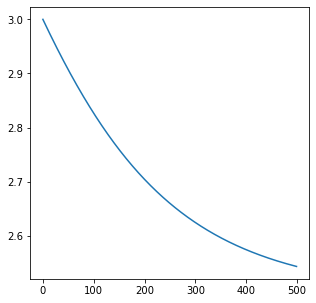

In [101]:
plt.plot(p.T)

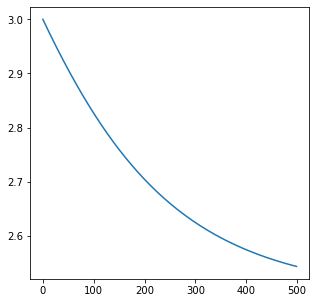

In [102]:
plt.plot(p2.T)

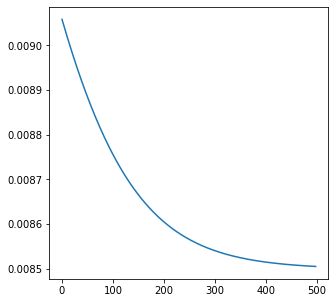

In [103]:
plt.plot(Fc.T)

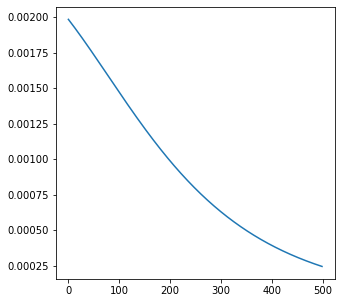

In [104]:
plt.plot(d.T)

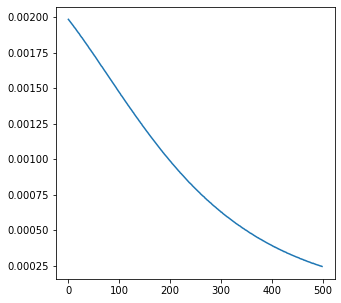

In [105]:
plt.plot(dTest.T)

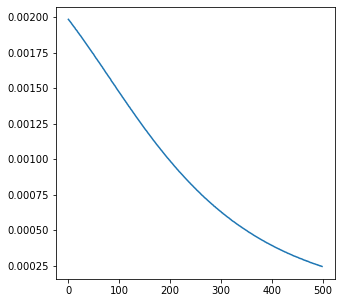

In [106]:
plt.plot(dTest2.T)

In [107]:
np.mean(np.sum((dTest-d)**2))

1.7415479389645816e-10

In [108]:
sum(c2)*dt

array([0.0085051])

In [109]:
dmL, dc,c=d_mLLambda(3,mInfer,yTrain,tlocL,meanZ)
print(dmL,sum(dc)*dt,sum(c)*dt)

[0.00198357] [-0.01786641] [0.00905829]


In [110]:
dmL2, dc2,c2=d_mLLambda(3+0.001,mInfer,yTrain,tlocL,meanZ)
print(dmL2,sum(dc2)*dt,sum(c2)*dt)

[0.00198592] [-0.01786746] [0.00906027]


In [111]:
(sum(c2)*dt-sum(c)*dt)/0.001

array([0.00198474])

In [112]:
mInfer.k_0

-1.0

In [113]:
def FullCost(x,model,obs,tloc,z):
    model.kernel.l2=x
    dt,dt2,Nt = model.getGridStepSize()
    source=model.computeSourceFromPhi(z)
    # compute concentration with new parameters
    conc=model.computeConcentration(source)
    
    #compute cost derivative and cost
    dc=dcost(obs,tloc,conc,model)
    c1=cost(obs,tloc,conc,model)
    
    c = np.sum(c1)*dt
    
    return c

In [115]:
c = FullCost(2,mInfer,yTrain,tlocL,meanZ)

In [116]:
c

array([0.00901379])

In [117]:
def FullDeriv(x,model,obs,tloc,source):
    model.kernel.l2=x 

    
    # calculate useful valyes
    dt,dt2,Nt = model.getGridStepSize()
    source=model.computeSourceFromPhi(z)
    # compute concentration with new parameters
    conc=model.computeConcentration(source)
    
    #compute cost derivative and cost
    dc=dcost(obs,tloc,conc,model)
    c=cost(obs,tloc,conc,model)
    
    # derivative of h operator with respect to parameters
    
    dmH=-computeSourceDerivative(model,z)/model.k_0

    # compute and calculate Lagrangian derivative integral
    integrand = -computeGradientAdjoint(dc,model)*dmH.T
    L_m = np.trapz(integrand,dx=dt)
    #L_m = np.sum(integrand)*dt
    return L_m

In [118]:
FullDeriv(3,mInfer,yTrain,tlocL,meanZ)

array([0.00189831])

In [119]:
from scipy.optimize import minimize

In [139]:
#x0 = [u+0.001,eta+0.001,k_0+0.001,2+0.001]
x0=0.6

In [140]:
result = minimize(FullCost,x0, method='BFGS', jac=FullDeriv,args=(mInfer,yTrain,tlocL,meanZ),options={'disp': True})#,tol=1e-8)

         Current function value: 0.000008
         Iterations: 0
         Function evaluations: 60
         Gradient evaluations: 48


In [141]:
result

      fun: 8.07373714063919e-06
 hess_inv: array([[1]])
      jac: array([-0.0308957])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 60
      nit: 0
     njev: 48
   status: 2
  success: False
        x: array([0.6])

In [142]:
fc = np.zeros(1000)
dc = np.zeros(1000)
x=np.linspace(0.1,5,1000)
for i in range(1000):
    fc[i] = FullCost(x[i],mInfer,yTrain,tlocL,meanZ)
    dc[i] = FullDeriv(x[i],mInfer,yTrain,tlocL,meanZ)

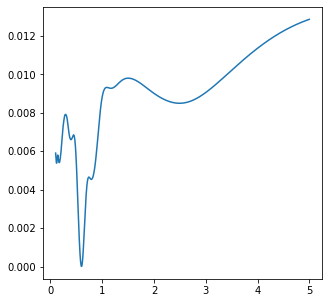

In [143]:
plt.plot(x,fc)

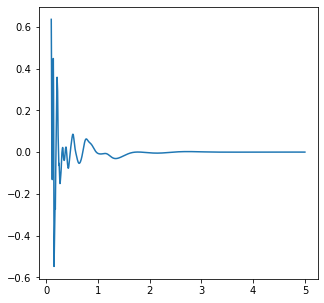

In [144]:
plt.plot(x,dc)

In [145]:
def FullDeriv(x,model,obs,tloc,z):
    model.k_0=x[2]
    model.u=x[0]
    model.eta=x[1]
    model.kernel.l2=x[3]

    
    # calculate useful valyes
    dt,dt2,Nt = model.getGridStepSize()
    source=model.computeSourceFromPhi(z)
    # compute concentration with new parameters
    conc=model.computeConcentration(source)
    
    #compute cost derivative and cost
    dc=dcost(obs,tloc,conc,model)
    c=cost(obs,tloc,conc,model)
    
    # derivative of h operator with respect to parameters
    dmH=np.array([np.gradient(conc,dt[0])/model.k_0,conc/model.k_0,(-model.u*np.gradient(conc,dt[0])-model.eta*conc+source)/model.k_0**2],-computeSourceDerivative(model,z)/model.k_0)

    # compute and calculate Lagrangian derivative integral
    integrand = -computeGradientAdjoint(dc,model)*dmH
    L_m = np.trapz(integrand,dx=dt)
    #
    L_m = np.sum(integrand)*dt
    return L_m

In [146]:
def FullCost(x,model,obs,tloc,z):
    model.k_0=x[2]
    model.u=x[0]
    model.eta=x[1]
    model.kernel.l2=x[3]
    dt,dt2,Nt = model.getGridStepSize()
    source=model.computeSourceFromPhi(z)
    # compute concentration with new parameters
    conc=model.computeConcentration(source)
    
    #compute cost derivative and cost
    dc=dcost(obs,tloc,conc,model)
    c1=cost(obs,tloc,conc,model)
    
    c = np.sum(c1)*dt
    
    return c